In [1]:
#change Kernel to "...tensorflow_27
#we are importing packages

import scipy.io
import scipy.misc
import tensorflow as tf
import numpy as np
import time
from IPython.display import Image

from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave #to be able to save as an image
from scipy.optimize import fmin_l_bfgs_b #to optimize our cost function

from keras.applications import vgg19 #to load vgg19 network
from keras import backend as K

Using TensorFlow backend.


In [2]:
import keras
print(tf.__version__)
print(keras.__version__)

from keras.utils.vis_utils import plot_model #to be able to visualize the network
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

1.4.0
2.1.2


In [3]:
content_file_name = '1-content.jpg'#content image
style_file_name = '2-style-liechtenstein.jpg'#style image

In [27]:
iterations = 5 #we will run 20 iterations during the optiomization. each iteration you get better value. this one is for about 15 min. running. 

# these are the weights of the different loss components
total_variation_weight = 8.5E-05#1.0 
style_weight = 1.0 #the best number authors got from their trials 
content_weight = 0.025 #the best number authors got from their trials 

In [5]:
# let's load images

base_image_path = './video_frames/'#+content_file_name
style_reference_image_path = './video_frames/'+style_file_name

# get dimensions (width, height) of the generated picture
width, height = load_img(base_image_path+'image_0001.png').size

img_nrows = 400 #recale the image to 400 pixel rows 
img_ncols = int(width * img_nrows / height)

In [6]:
# pre-process the image: rescaling, running it through VGG19

def preprocess_image(image_path):

    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img


# utility function to convert a tensor into a valid image

def deprocess_image(x):

    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))

    else:

        x = x.reshape((img_nrows, img_ncols, 3))

    # Remove zero-center by mean pixel

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # 'BGR'->'RGB'

    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#calculating the mean pixel values of the VGG network. We will use these values for normalization.
#mean = data['meta'][0][0][2][0][0][2]
#mean_pixel = np.mean(mean, axis=(0, 1))
#print(mean_pixel)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


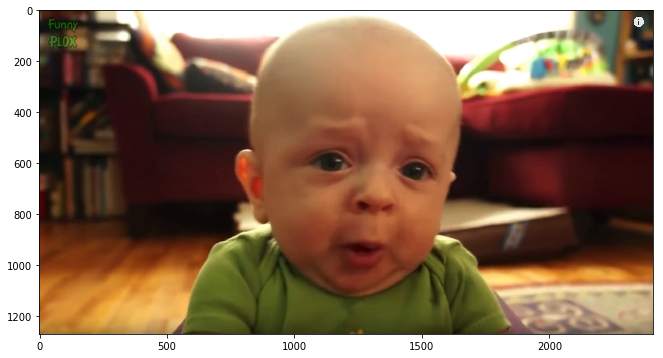

In [7]:
image_content = scipy.misc.imread(base_image_path+'image_0001.png')
#image_content= scipy.misc.imresize(image_content,(224,224))
plt.figure(figsize=(11,11))
plt.imshow(image_content)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


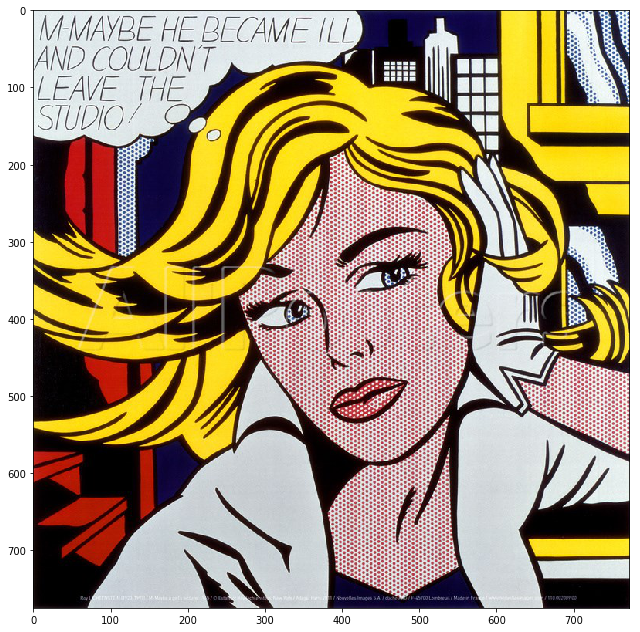

In [8]:
image_style = scipy.misc.imread(style_reference_image_path)
#image_content= scipy.misc.imresize(image_content,(224,224))
plt.figure(figsize=(11,11))
plt.imshow(image_style)



In [9]:
# get tensor representations of our images
# base_images = []

# for i in range(1, 11):
# base_image_path = './video_frames/image_' + str(i).zfill(4) + '.png'
base_image_path = './video_frames/image_' + '0001.png'
base_image = K.variable(preprocess_image(base_image_path))
#     base_images.append(base_image)

style_reference_image = K.variable(preprocess_image(style_reference_image_path))
# style_reference_images = [style_reference_image] * 10

# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))


# combine the 3 images (style, content, result image that starts from the white noise) into a single Keras tensor

input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [10]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights

model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


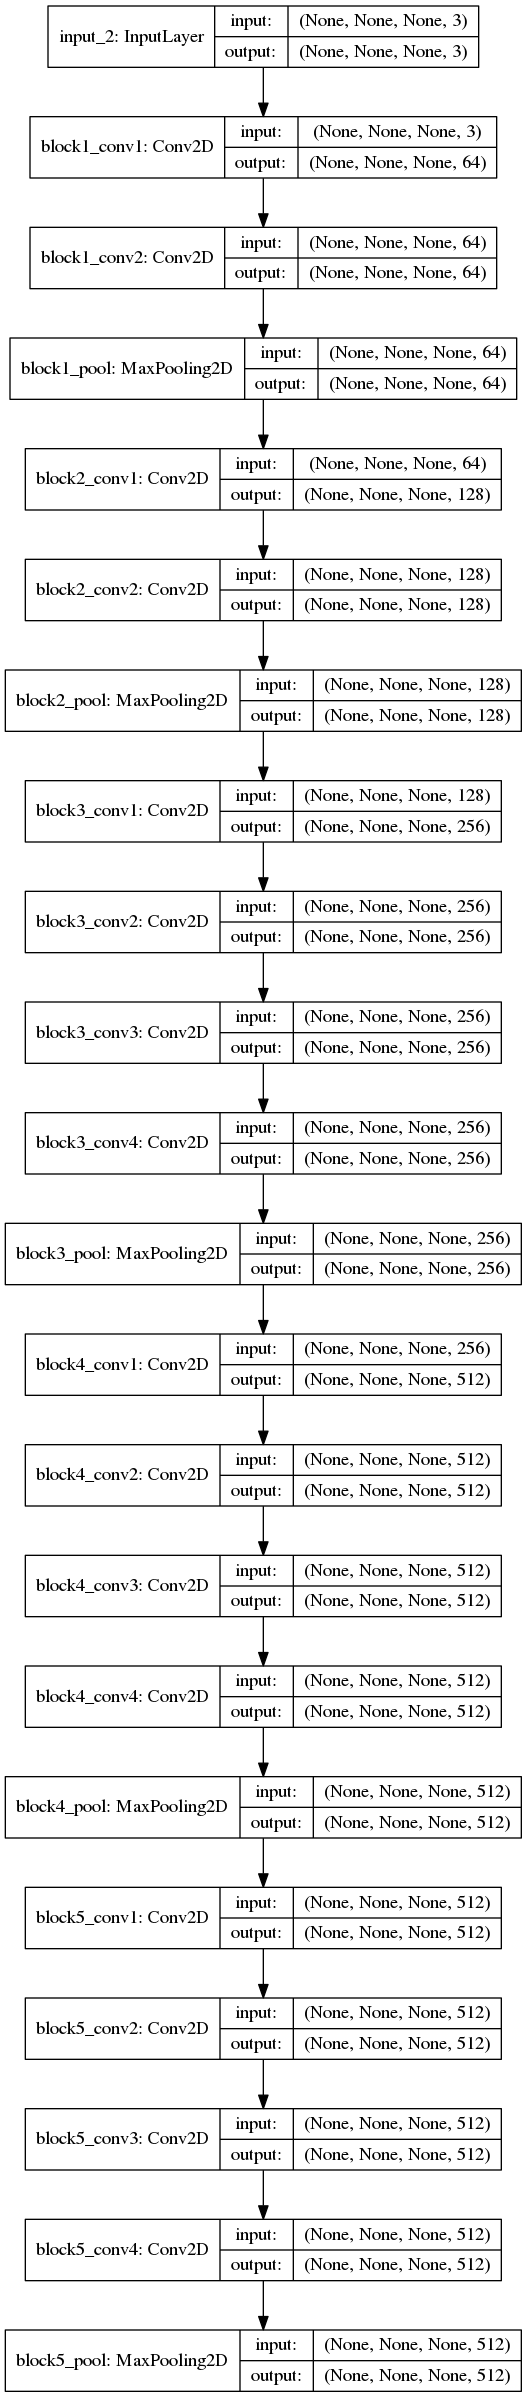

In [33]:
plot_model(model, show_shapes=True, to_file='./images/model.png')
Image("./images/model.png")

In [11]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [70]:
for l, layer in enumerate(model.layers):
    print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
# compute the neural style loss
# first we need to define 4 utility functions
# the gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):

    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))

    gram = K.dot(features, K.transpose(features))
    return gram

In [13]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):

    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3

    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


In [14]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [15]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent (no big changes)

def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':

        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [16]:
# combine these loss functions into a single scalar

loss = K.variable(0.)
layer_features = outputs_dict['block5_conv2'] #content features
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

In [18]:
# style_features
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

In [19]:
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

loss += total_variation_weight * total_variation_loss(combination_image)

In [20]:
# get the gradients of the generated image wrt the loss

grads = K.gradients(loss, combination_image)
outputs = [loss]

if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

In [21]:
def eval_loss_and_grads(x):

    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))

    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values



In [22]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [23]:
evaluator = Evaluator()

In [82]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
# x = preprocess_image(base_image_path)
# for i in range(1, 11):
#     base_image_path = './video_frames/image_' + str(i).zfill(4) + '.png'
#     base_image = K.variable(preprocess_image(base_image_path))
#     base_images.append(base_image)

In [25]:
result_prefix ='./images/liechtenstein_'

In [28]:
# minimise the loss function
imgs = []
for outer in range(2, 203):
    x_path = './video_frames/image_' + str(outer).zfill(4) + '.png'
    x = preprocess_image(x_path)
    for i in range(iterations):
#         print('XXXX shape', x.shape)
        print('Start of iteration', i)
        start_time = time.time()

        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                         fprime=evaluator.grads, maxfun=20)

        print('Current loss value:', min_val)
        # save current generated image

        img = deprocess_image(x.copy())
        imgs.append(img)
        fname = result_prefix + '_at_iteration_%d_%04d.png' % (i,outer)
        imsave(fname, img)
        end_time = time.time()

        print('Image saved as', fname)
        print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2.19712e+10
Image saved as ./images/liechtenstein__at_iteration_0_0002.png
Iteration 0 completed in 25s
Start of iteration 1


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 6.90589e+09
Image saved as ./images/liechtenstein__at_iteration_1_0002.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.11228e+09
Image saved as ./images/liechtenstein__at_iteration_2_0002.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.84924e+09
Image saved as ./images/liechtenstein__at_iteration_3_0002.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.12893e+09
Image saved as ./images/liechtenstein__at_iteration_4_0002.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.22161e+10
Image saved as ./images/liechtenstein__at_iteration_0_0003.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.44527e+09
Image saved as ./images/liechtenstein__at_iteration_1_0003.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.26373e+09
Image saved as ./images/liechtenstein__at_iteration_2_0003.png
Iteration 2 completed in 25s
Start 

Current loss value: 2.79932e+09
Image saved as ./images/liechtenstein__at_iteration_3_0013.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.161e+09
Image saved as ./images/liechtenstein__at_iteration_4_0013.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.54181e+10
Image saved as ./images/liechtenstein__at_iteration_0_0014.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.08456e+09
Image saved as ./images/liechtenstein__at_iteration_1_0014.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 3.9122e+09
Image saved as ./images/liechtenstein__at_iteration_2_0014.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.65564e+09
Image saved as ./images/liechtenstein__at_iteration_3_0014.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.0906e+09
Image saved as ./images/liechtenstein__at_iteration_4_0014.png
Iteration 4 completed in 25s
Start of i

Current loss value: 2.52517e+10
Image saved as ./images/liechtenstein__at_iteration_0_0025.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.31004e+09
Image saved as ./images/liechtenstein__at_iteration_1_0025.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.22846e+09
Image saved as ./images/liechtenstein__at_iteration_2_0025.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.86778e+09
Image saved as ./images/liechtenstein__at_iteration_3_0025.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.2246e+09
Image saved as ./images/liechtenstein__at_iteration_4_0025.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.56031e+10
Image saved as ./images/liechtenstein__at_iteration_0_0026.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.09997e+09
Image saved as ./images/liechtenstein__at_iteration_1_0026.png
Iteration 1 completed in 25s
Start o

Current loss value: 4.03402e+09
Image saved as ./images/liechtenstein__at_iteration_2_0036.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.82342e+09
Image saved as ./images/liechtenstein__at_iteration_3_0036.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.07444e+09
Image saved as ./images/liechtenstein__at_iteration_4_0036.png
Iteration 4 completed in 26s
Start of iteration 0
Current loss value: 2.57651e+10
Image saved as ./images/liechtenstein__at_iteration_0_0037.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.17173e+09
Image saved as ./images/liechtenstein__at_iteration_1_0037.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.08261e+09
Image saved as ./images/liechtenstein__at_iteration_2_0037.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.73979e+09
Image saved as ./images/liechtenstein__at_iteration_3_0037.png
Iteration 3 completed in 25s
Start 

Current loss value: 2.40362e+09
Image saved as ./images/liechtenstein__at_iteration_4_0047.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.20886e+10
Image saved as ./images/liechtenstein__at_iteration_0_0048.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 6.92281e+09
Image saved as ./images/liechtenstein__at_iteration_1_0048.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 3.97153e+09
Image saved as ./images/liechtenstein__at_iteration_2_0048.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.82437e+09
Image saved as ./images/liechtenstein__at_iteration_3_0048.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.20537e+09
Image saved as ./images/liechtenstein__at_iteration_4_0048.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.18828e+10
Image saved as ./images/liechtenstein__at_iteration_0_0049.png
Iteration 0 completed in 25s
Start 

Current loss value: 7.69008e+09
Image saved as ./images/liechtenstein__at_iteration_1_0059.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.4723e+09
Image saved as ./images/liechtenstein__at_iteration_2_0059.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 3.03765e+09
Image saved as ./images/liechtenstein__at_iteration_3_0059.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.27191e+09
Image saved as ./images/liechtenstein__at_iteration_4_0059.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.75432e+10
Image saved as ./images/liechtenstein__at_iteration_0_0060.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 8.13563e+09
Image saved as ./images/liechtenstein__at_iteration_1_0060.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.48495e+09
Image saved as ./images/liechtenstein__at_iteration_2_0060.png
Iteration 2 completed in 25s
Start o

Current loss value: 2.90501e+09
Image saved as ./images/liechtenstein__at_iteration_3_0070.png
Iteration 3 completed in 27s
Start of iteration 4
Current loss value: 2.24324e+09
Image saved as ./images/liechtenstein__at_iteration_4_0070.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.81465e+10
Image saved as ./images/liechtenstein__at_iteration_0_0071.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 8.24606e+09
Image saved as ./images/liechtenstein__at_iteration_1_0071.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.43952e+09
Image saved as ./images/liechtenstein__at_iteration_2_0071.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 3.182e+09
Image saved as ./images/liechtenstein__at_iteration_3_0071.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.43545e+09
Image saved as ./images/liechtenstein__at_iteration_4_0071.png
Iteration 4 completed in 25s
Start of

Current loss value: 2.80809e+10
Image saved as ./images/liechtenstein__at_iteration_0_0082.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 8.26279e+09
Image saved as ./images/liechtenstein__at_iteration_1_0082.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.79505e+09
Image saved as ./images/liechtenstein__at_iteration_2_0082.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 3.29115e+09
Image saved as ./images/liechtenstein__at_iteration_3_0082.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.54234e+09
Image saved as ./images/liechtenstein__at_iteration_4_0082.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.83482e+10
Image saved as ./images/liechtenstein__at_iteration_0_0083.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 8.12438e+09
Image saved as ./images/liechtenstein__at_iteration_1_0083.png
Iteration 1 completed in 25s
Start 

Current loss value: 4.26489e+09
Image saved as ./images/liechtenstein__at_iteration_2_0093.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.96879e+09
Image saved as ./images/liechtenstein__at_iteration_3_0093.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.33025e+09
Image saved as ./images/liechtenstein__at_iteration_4_0093.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.67505e+10
Image saved as ./images/liechtenstein__at_iteration_0_0094.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.43555e+09
Image saved as ./images/liechtenstein__at_iteration_1_0094.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.41496e+09
Image saved as ./images/liechtenstein__at_iteration_2_0094.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 3.00785e+09
Image saved as ./images/liechtenstein__at_iteration_3_0094.png
Iteration 3 completed in 25s
Start 

Current loss value: 2.33395e+09
Image saved as ./images/liechtenstein__at_iteration_4_0104.png
Iteration 4 completed in 27s
Start of iteration 0
Current loss value: 2.27033e+10
Image saved as ./images/liechtenstein__at_iteration_0_0105.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.12979e+09
Image saved as ./images/liechtenstein__at_iteration_1_0105.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.17366e+09
Image saved as ./images/liechtenstein__at_iteration_2_0105.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.98455e+09
Image saved as ./images/liechtenstein__at_iteration_3_0105.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.30153e+09
Image saved as ./images/liechtenstein__at_iteration_4_0105.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.32208e+10
Image saved as ./images/liechtenstein__at_iteration_0_0106.png
Iteration 0 completed in 25s
Start 

Current loss value: 6.77412e+09
Image saved as ./images/liechtenstein__at_iteration_1_0116.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.10125e+09
Image saved as ./images/liechtenstein__at_iteration_2_0116.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.9404e+09
Image saved as ./images/liechtenstein__at_iteration_3_0116.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.24341e+09
Image saved as ./images/liechtenstein__at_iteration_4_0116.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.25084e+10
Image saved as ./images/liechtenstein__at_iteration_0_0117.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.19285e+09
Image saved as ./images/liechtenstein__at_iteration_1_0117.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.07734e+09
Image saved as ./images/liechtenstein__at_iteration_2_0117.png
Iteration 2 completed in 25s
Start o

Current loss value: 2.98892e+09
Image saved as ./images/liechtenstein__at_iteration_3_0127.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.3344e+09
Image saved as ./images/liechtenstein__at_iteration_4_0127.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.68699e+10
Image saved as ./images/liechtenstein__at_iteration_0_0128.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.87581e+09
Image saved as ./images/liechtenstein__at_iteration_1_0128.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.46886e+09
Image saved as ./images/liechtenstein__at_iteration_2_0128.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 3.12524e+09
Image saved as ./images/liechtenstein__at_iteration_3_0128.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.37461e+09
Image saved as ./images/liechtenstein__at_iteration_4_0128.png
Iteration 4 completed in 25s
Start o

Current loss value: 2.21606e+10
Image saved as ./images/liechtenstein__at_iteration_0_0139.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.05305e+09
Image saved as ./images/liechtenstein__at_iteration_1_0139.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.05248e+09
Image saved as ./images/liechtenstein__at_iteration_2_0139.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 3.06184e+09
Image saved as ./images/liechtenstein__at_iteration_3_0139.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.35395e+09
Image saved as ./images/liechtenstein__at_iteration_4_0139.png
Iteration 4 completed in 26s
Start of iteration 0
Current loss value: 2.3192e+10
Image saved as ./images/liechtenstein__at_iteration_0_0140.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.14616e+09
Image saved as ./images/liechtenstein__at_iteration_1_0140.png
Iteration 1 completed in 25s
Start o

Current loss value: 4.03031e+09
Image saved as ./images/liechtenstein__at_iteration_2_0150.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.98489e+09
Image saved as ./images/liechtenstein__at_iteration_3_0150.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.27974e+09
Image saved as ./images/liechtenstein__at_iteration_4_0150.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.13338e+10
Image saved as ./images/liechtenstein__at_iteration_0_0151.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.23301e+09
Image saved as ./images/liechtenstein__at_iteration_1_0151.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.3505e+09
Image saved as ./images/liechtenstein__at_iteration_2_0151.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.9647e+09
Image saved as ./images/liechtenstein__at_iteration_3_0151.png
Iteration 3 completed in 25s
Start of

Current loss value: 2.24538e+09
Image saved as ./images/liechtenstein__at_iteration_4_0161.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.1278e+10
Image saved as ./images/liechtenstein__at_iteration_0_0162.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 6.82805e+09
Image saved as ./images/liechtenstein__at_iteration_1_0162.png
Iteration 1 completed in 26s
Start of iteration 2
Current loss value: 4.02586e+09
Image saved as ./images/liechtenstein__at_iteration_2_0162.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.96593e+09
Image saved as ./images/liechtenstein__at_iteration_3_0162.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.26176e+09
Image saved as ./images/liechtenstein__at_iteration_4_0162.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.20791e+10
Image saved as ./images/liechtenstein__at_iteration_0_0163.png
Iteration 0 completed in 25s
Start o

Current loss value: 6.91371e+09
Image saved as ./images/liechtenstein__at_iteration_1_0173.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.08183e+09
Image saved as ./images/liechtenstein__at_iteration_2_0173.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.81197e+09
Image saved as ./images/liechtenstein__at_iteration_3_0173.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.19023e+09
Image saved as ./images/liechtenstein__at_iteration_4_0173.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.13669e+10
Image saved as ./images/liechtenstein__at_iteration_0_0174.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.21822e+09
Image saved as ./images/liechtenstein__at_iteration_1_0174.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.06578e+09
Image saved as ./images/liechtenstein__at_iteration_2_0174.png
Iteration 2 completed in 25s
Start 

Current loss value: 2.79877e+09
Image saved as ./images/liechtenstein__at_iteration_3_0184.png
Iteration 3 completed in 26s
Start of iteration 4
Current loss value: 2.20232e+09
Image saved as ./images/liechtenstein__at_iteration_4_0184.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.10626e+10
Image saved as ./images/liechtenstein__at_iteration_0_0185.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 6.90322e+09
Image saved as ./images/liechtenstein__at_iteration_1_0185.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.05657e+09
Image saved as ./images/liechtenstein__at_iteration_2_0185.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 2.8273e+09
Image saved as ./images/liechtenstein__at_iteration_3_0185.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.17859e+09
Image saved as ./images/liechtenstein__at_iteration_4_0185.png
Iteration 4 completed in 25s
Start o

Current loss value: 2.19918e+10
Image saved as ./images/liechtenstein__at_iteration_0_0196.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.26655e+09
Image saved as ./images/liechtenstein__at_iteration_1_0196.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 4.38092e+09
Image saved as ./images/liechtenstein__at_iteration_2_0196.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 3.07571e+09
Image saved as ./images/liechtenstein__at_iteration_3_0196.png
Iteration 3 completed in 25s
Start of iteration 4
Current loss value: 2.39454e+09
Image saved as ./images/liechtenstein__at_iteration_4_0196.png
Iteration 4 completed in 25s
Start of iteration 0
Current loss value: 2.1705e+10
Image saved as ./images/liechtenstein__at_iteration_0_0197.png
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 7.95205e+09
Image saved as ./images/liechtenstein__at_iteration_1_0197.png
Iteration 1 completed in 25s
Start o

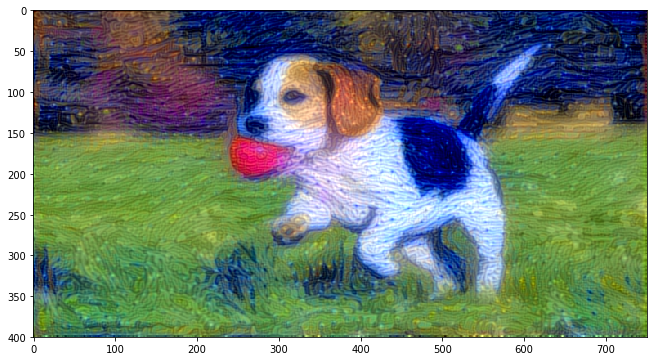

In [26]:
#image_content= scipy.misc.imresize(image_content,(224,224))
plt.figure(figsize=(11,11))
plt.imshow(img)